<a href="https://colab.research.google.com/github/shr8769/IBM_HR_Analytics_Employee_Attrition_-_Performance/blob/main/IBM_HR_Analytics_Employee_Attrition_%26_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#cell-1
# IBM HR Analytics — Employee Attrition & Performance (End-to-End)

#Domain: Data Analyst / Data Scientist
#Tools: Python, ML, SQL, Excel
#Difficulty: Intermediate

## Problem Statement
#Human Resources are critical to any organization. Attrition disrupts teams, burns money on hiring/training, and bleeds institutional knowledge. If HR can predict which employees are at risk, the org can act early—targeted retention or preventative hiring—to reduce impact.

## Objective
#Study factors such as salary, satisfaction, growth opportunities, policies, recognition, and work-life balance to:
#1 Measure attrition and its distribution across demographics/roles.
#2 Identify drivers correlated with attrition.
#3 Build a predictive model to flag risk.

## Hypotheses
#H1: Higher attrition -> higher cost (recruiting/training) and lost productivity/profit.
#H2: Poor work conditions, low satisfaction, weak recognition, and long commutes increase attrition probability.

## Approach (what we’ll actually do)
#Data audit, cleaning, and **ordinal mappings** as per spec.
#EDA with required breakdowns:
  #DistanceFromHome by JobRole × Attrition
  #MonthlyIncome by Education × Attrition
# Decision Tree with **StratifiedKFold (k=5). Report ROC-AUC and F1.
#SQL queries to mirror the business breakdowns.
#Exports (Excel + CSV) for submission.


In [28]:
#cell2
# Optional installs if needed on Colab:
# !pip -q install imbalanced-learn openpyxl

import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import sqlite3

plt.rcParams["figure.figsize"] = (6,4)
print("Setup OK.")


Setup OK.


In [30]:
#cell3
from google.colab import files
up = files.upload()
df = pd.read_excel(next(iter(up.keys())))

Saving WA_Fn-UseC_-HR-Employee-Attrition.xlsx to WA_Fn-UseC_-HR-Employee-Attrition.xlsx


In [31]:
#cell4
print("Shape:", df.shape)
display(df.isnull().sum().sort_values(ascending=False).head(10))
df.dtypes


Shape: (1470, 35)


,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


,0
Age,int64
Attrition,object
BusinessTravel,object
DailyRate,int64
Department,object
DistanceFromHome,int64
Education,int64
EducationField,object
EmployeeCount,int64
EmployeeNumber,int64


In [33]:
#Cell 5 — Add ordinal label columns (as per spec)
ordinal_maps = {
    "Education": {1:"Below College",2:"College",3:"Bachelor",4:"Master",5:"Doctor"},
    "EnvironmentSatisfaction": {1:"Low",2:"Medium",3:"High",4:"Very High"},
    "JobInvolvement": {1:"Low",2:"Medium",3:"High",4:"Very High"},
    "JobSatisfaction": {1:"Low",2:"Medium",3:"High",4:"Very High"},
    "PerformanceRating": {1:"Low",2:"Good",3:"Excellent",4:"Outstanding"},
    "RelationshipSatisfaction": {1:"Low",2:"Medium",3:"High",4:"Very High"},
    "WorkLifeBalance": {1:"Bad",2:"Good",3:"Better",4:"Best"}
}
for col, mapping in ordinal_maps.items():
    if col in df.columns and np.issubdtype(df[col].dtype, np.number):
        df[col + "_Label"] = df[col].map(mapping)

df.filter(regex="_Label$|^Education$|^WorkLifeBalance$").head(3)


,Education,WorkLifeBalance,Education_Label,EnvironmentSatisfaction_Label,JobInvolvement_Label,JobSatisfaction_Label,PerformanceRating_Label,RelationshipSatisfaction_Label,WorkLifeBalance_Label
0,2,1,College,Medium,High,Very High,Excellent,Low,Bad
1,1,3,Below College,High,Medium,Medium,Outstanding,Very High,Better
2,2,3,College,Very High,Medium,High,Excellent,Medium,Better


Attrition
No     83.88
Yes    16.12
Average years at company: 7.01


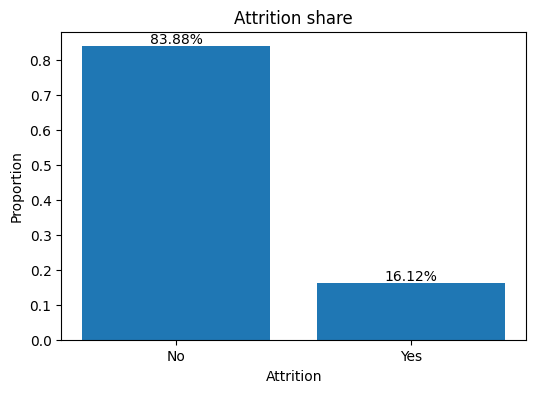

In [34]:
#Cell 6 — Target distribution + tenure stat
attrition_share = df["Attrition"].value_counts(normalize=True).rename("proportion")*100
print(attrition_share.round(2).to_string())
print("Average years at company:", round(df["YearsAtCompany"].mean(),2))

# Bar chart
vals = df["Attrition"].value_counts(normalize=True).sort_index()
plt.bar(vals.index, vals.values)
for i,(k,v) in enumerate(vals.items()):
    plt.text(i, v, f"{v*100:.2f}%", ha="center", va="bottom")
plt.title("Attrition share"); plt.xlabel("Attrition"); plt.ylabel("Proportion")
plt.show()


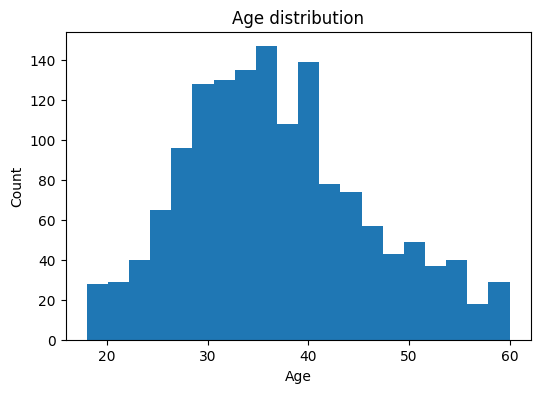

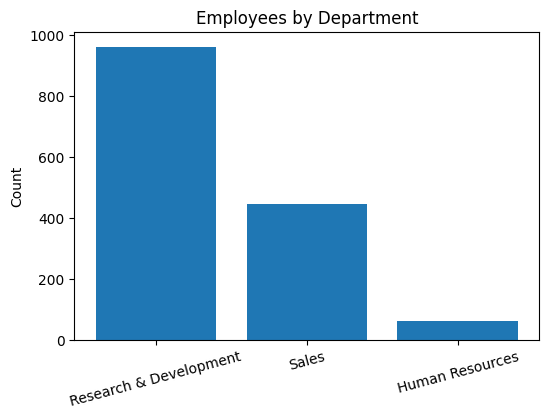

In [35]:
#Cell 7 — Demographics quick view
# Age distribution
plt.hist(df["Age"], bins=20)
plt.title("Age distribution"); plt.xlabel("Age"); plt.ylabel("Count")
plt.show()

# Department counts
dept_counts = df["Department"].value_counts()
plt.bar(dept_counts.index, dept_counts.values)
plt.title("Employees by Department"); plt.xticks(rotation=15)
plt.ylabel("Count")
plt.show()


,JobRole,Attrition,count,mean,median,min,max
0,Healthcare Representative,No,122.0,9.204918,7.0,1.0,29.0
1,Healthcare Representative,Yes,9.0,17.666667,20.0,2.0,29.0
2,Human Resources,No,40.0,6.600000,3.5,1.0,26.0
3,Human Resources,Yes,12.0,13.416667,15.0,1.0,23.0
4,Laboratory Technician,No,197.0,9.329949,7.0,1.0,29.0
5,Laboratory Technician,Yes,62.0,9.661290,7.0,1.0,29.0
6,Manager,No,97.0,7.927835,4.0,1.0,29.0
7,Manager,Yes,5.0,10.000000,2.0,2.0,29.0
8,Manufacturing Director,No,135.0,9.533333,7.0,1.0,29.0
9,Manufacturing Director,Yes,10.0,8.800000,7.5,1.0,23.0


Attrition,No,Yes
JobRole,,
Healthcare Representative,9.204918,17.666667
Human Resources,6.600000,13.416667
Laboratory Technician,9.329949,9.661290
Manager,7.927835,10.000000
Manufacturing Director,9.533333,8.800000
Research Director,8.474359,7.000000
Research Scientist,8.869388,9.765957
Sales Executive,9.026022,12.649123
Sales Representative,9.000000,8.151515


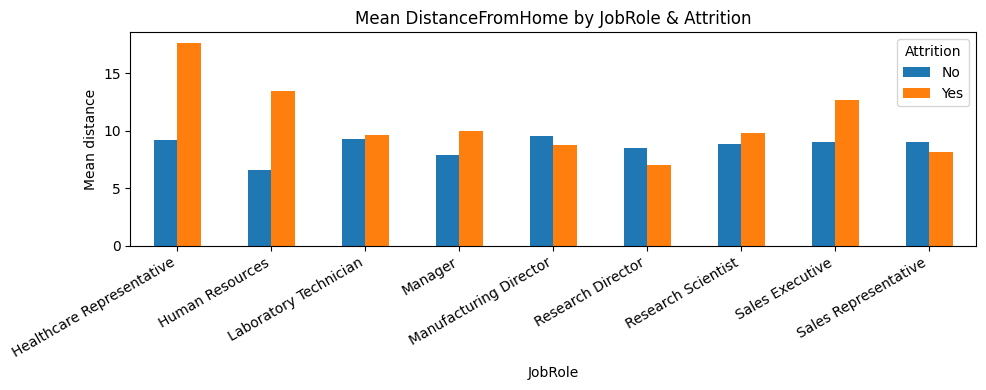

In [36]:
#Cell 8 — Required breakdown #1: DistanceFromHome by JobRole × Attrition
dist_tbl = df.groupby(["JobRole","Attrition"])["DistanceFromHome"].describe()[["count","mean","50%","min","max"]].reset_index()
dist_tbl = dist_tbl.rename(columns={"50%":"median"})
display(dist_tbl.head(10))

pivot_dist = df.pivot_table(index="JobRole", columns="Attrition", values="DistanceFromHome", aggfunc="mean")
display(pivot_dist)

pivot_dist.plot(kind="bar", figsize=(10,4))
plt.title("Mean DistanceFromHome by JobRole & Attrition"); plt.ylabel("Mean distance")
plt.xticks(rotation=30, ha="right"); plt.legend(title="Attrition")
plt.tight_layout()
plt.show()


Attrition,No,Yes
Education,,
1,5926.129496,4360.161290
2,6586.058824,4282.545455
3,6882.919662,4770.242424
4,7087.814706,5335.155172
5,8559.906977,5850.200000


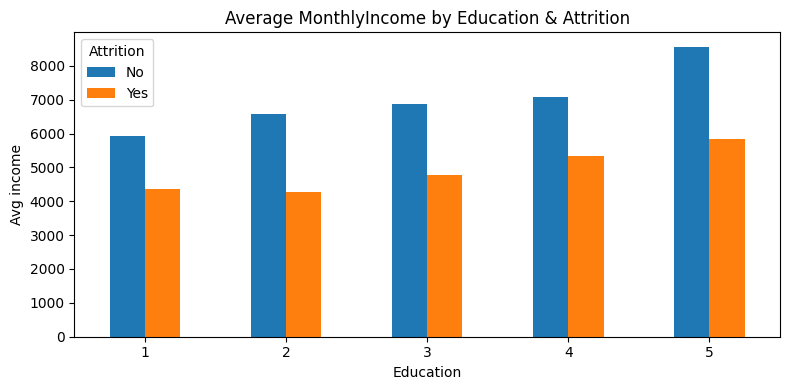

In [37]:
#Cell 9 — Required breakdown #2: MonthlyIncome by Education × Attrition
pivot_income = df.pivot_table(index="Education", columns="Attrition", values="MonthlyIncome", aggfunc="mean")
display(pivot_income)

pivot_income.plot(kind="bar", figsize=(8,4))
plt.title("Average MonthlyIncome by Education & Attrition"); plt.ylabel("Avg income")
plt.xticks(rotation=0); plt.legend(title="Attrition")
plt.tight_layout()
plt.show()


In [40]:
#  CELL-10 -

# Target as 1/0
y = (df["Attrition"].astype(str).str.strip().str.lower() == "yes").astype(int)

# Drop leakage/constant/id-like
drop_cols = ["Attrition","EmployeeNumber","Over18","EmployeeCount","StandardHours"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

# Identify true categoricals (excluding *_Label duplicates)
# Keep numeric ORDINALS as numeric. Use *_Label only for reporting, not modeling.
label_cols = [c for c in X.columns if c.endswith("_Label")]
X = X.drop(columns=label_cols)  # <- critical: drop duplicated categorical labels from model features

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocess = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("scale",  StandardScaler(with_mean=False),          num_cols),
])

print(f"Cat cols: {len(cat_cols)} | Num cols: {len(num_cols)}")
print("Class balance:", y.value_counts(normalize=True).round(3).to_dict())


Cat cols: 7 | Num cols: 23
Class balance: {0: 0.839, 1: 0.161}


Best params: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__min_samples_leaf': 20, 'clf__min_samples_split': 2}
CV best AUC: 0.7324
Holdout AUC: 0.6799
Best threshold for F1 on holdout: 0.31, F1=0.3969

--- Report @ t* ---
              precision    recall  f1-score   support

           0      0.889     0.851     0.869       309
           1      0.361     0.441     0.397        59

    accuracy                          0.785       368
   macro avg      0.625     0.646     0.633       368
weighted avg      0.804     0.785     0.794       368


--- Report @ 0.5 (for reference) ---
              precision    recall  f1-score   support

           0      0.877     0.945     0.910       309
           1      0.514     0.305     0.383        59

    accuracy                          0.842       368
   macro avg      0.696     0.625     0.646       368
weighted avg      0.819     0.842     0.825       368



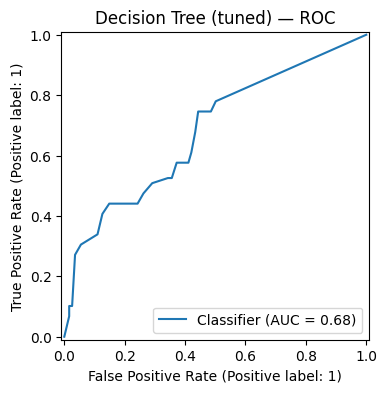

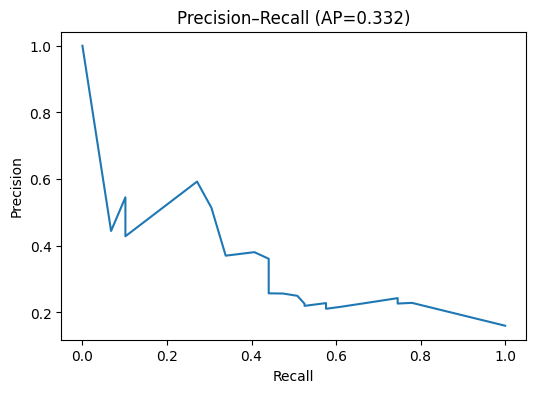

In [42]:
 #CELL-11

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, RocCurveDisplay, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

# Holdout split for final reporting
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Sensible grid for imbalanced DT
param_grid = {
    "clf__class_weight": [None, "balanced"],
    "clf__max_depth": [3, 5, 7, 10, None],
    "clf__min_samples_leaf": [1, 5, 10, 20],
    "clf__min_samples_split": [2, 10, 20]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    pipe, param_grid=param_grid, scoring="roc_auc",
    cv=cv, n_jobs=-1, verbose=0
)
gs.fit(X_tr, y_tr)

best = gs.best_estimator_
print("Best params:", gs.best_params_)
print("CV best AUC:", round(gs.best_score_, 4))

# Holdout evaluation
proba_te = best.predict_proba(X_te)[:,1]
auc_te = roc_auc_score(y_te, proba_te)
print("Holdout AUC:", round(auc_te, 4))

# Threshold sweep to maximize F1 (don’t freeze at 0.5)
ts = np.linspace(0.05, 0.6, 56)
f1s = [f1_score(y_te, (proba_te >= t).astype(int)) for t in ts]
t_star = ts[int(np.argmax(f1s))]
print(f"Best threshold for F1 on holdout: {t_star:.2f}, F1={max(f1s):.4f}")

# Final report at t* and at 0.5 for comparison
print("\n--- Report @ t* ---")
print(classification_report(y_te, (proba_te >= t_star).astype(int), digits=3))

print("\n--- Report @ 0.5 (for reference) ---")
print(classification_report(y_te, (proba_te >= 0.5).astype(int), digits=3))

# Curves
RocCurveDisplay.from_predictions(y_te, proba_te)
plt.title("Decision Tree (tuned) — ROC"); plt.show()

prec, rec, thr = precision_recall_curve(y_te, proba_te)
ap = average_precision_score(y_te, proba_te)
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP={ap:.3f})"); plt.show()


In [43]:
#Cell-11b
# If FN (missed leaver) is 5x as costly as FP, maximize expected utility:
cost_fp = 1.0
cost_fn = 5.0

def expected_cost(t):
    pred = (proba_te >= t).astype(int)
    fp = np.sum((pred==1) & (y_te==0))
    fn = np.sum((pred==0) & (y_te==1))
    return fp*cost_fp + fn*cost_fn

ts = np.linspace(0.05, 0.9, 86)
costs = [expected_cost(t) for t in ts]
best_t_cost = ts[int(np.argmin(costs))]
print(f"Cost-optimal threshold: {best_t_cost:.2f}, expected cost: {min(costs)}")


Cost-optimal threshold: 0.31, expected cost: 211.0


In [44]:
#Cell-11c
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced_subsample",
        max_depth=None, min_samples_leaf=5
    ))
])

rf_pipe.fit(X_tr, y_tr)
proba_rf = rf_pipe.predict_proba(X_te)[:,1]
print("RF Holdout AUC:", round(roc_auc_score(y_te, proba_rf),4))

# F1-opt threshold
ts = np.linspace(0.05, 0.6, 56)
f1s = [f1_score(y_te, (proba_rf >= t).astype(int)) for t in ts]
t_rf = ts[int(np.argmax(f1s))]
print(f"RF best t={t_rf:.2f} | F1={max(f1s):.4f}")

print("\nRF report @ t*: \n", classification_report(y_te, (proba_rf >= t_rf).astype(int), digits=3))


RF Holdout AUC: 0.7697
RF best t=0.37 | F1=0.5333

RF report @ t*: 
               precision    recall  f1-score   support

           0      0.921     0.871     0.895       309
           1      0.474     0.610     0.533        59

    accuracy                          0.829       368
   macro avg      0.697     0.740     0.714       368
weighted avg      0.849     0.829     0.837       368



In [45]:
#Cell-11d
# !pip -q install xgboost lightgbm
import numpy as np
from xgboost import XGBClassifier

xgb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", XGBClassifier(
        random_state=42, n_estimators=500, learning_rate=0.05, max_depth=3,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, n_jobs=-1,
        eval_metric="auc", scale_pos_weight=(y_tr.value_counts()[0] / y_tr.value_counts()[1])
    ))
])

xgb_pipe.fit(X_tr, y_tr)
proba_xgb = xgb_pipe.predict_proba(X_te)[:,1]
print("XGB Holdout AUC:", round(roc_auc_score(y_te, proba_xgb),4))

ts = np.linspace(0.05, 0.6, 56)
f1s = [f1_score(y_te, (proba_xgb >= t).astype(int)) for t in ts]
t_xgb = ts[int(np.argmax(f1s))]
print(f"XGB best t={t_xgb:.2f} | F1={max(f1s):.4f}")
print("\nXGB report @ t*:\n", classification_report(y_te, (proba_xgb >= t_xgb).astype(int), digits=3))


XGB Holdout AUC: 0.7783
XGB best t=0.33 | F1=0.5075

XGB report @ t*:
               precision    recall  f1-score   support

           0      0.915     0.867     0.890       309
           1      0.453     0.576     0.507        59

    accuracy                          0.821       368
   macro avg      0.684     0.722     0.699       368
weighted avg      0.841     0.821     0.829       368



In [46]:
#cell 12
# Threshold sweep to see best F1 on the holdout
probs = proba_te
best_t, best_f1 = 0.5, -1
for t in np.linspace(0.1, 0.9, 81):
    f1t = f1_score(y_te, (probs>=t).astype(int))
    if f1t > best_f1:
        best_f1, best_t = f1t, t
print(f"Best threshold: {best_t:.2f} with F1={best_f1:.4f}")


Best threshold: 0.30 with F1=0.3969


,feature,importance
0,OverTime_No,0.022283
1,OverTime_Yes,0.022011
2,DistanceFromHome,0.007337
3,MaritalStatus_Single,0.006793
4,MonthlyIncome,0.005978
5,JobLevel,0.005707
6,EnvironmentSatisfaction,0.005163
7,StockOptionLevel,0.004076
8,WorkLifeBalance,0.003533
9,Department_Sales,0.002446


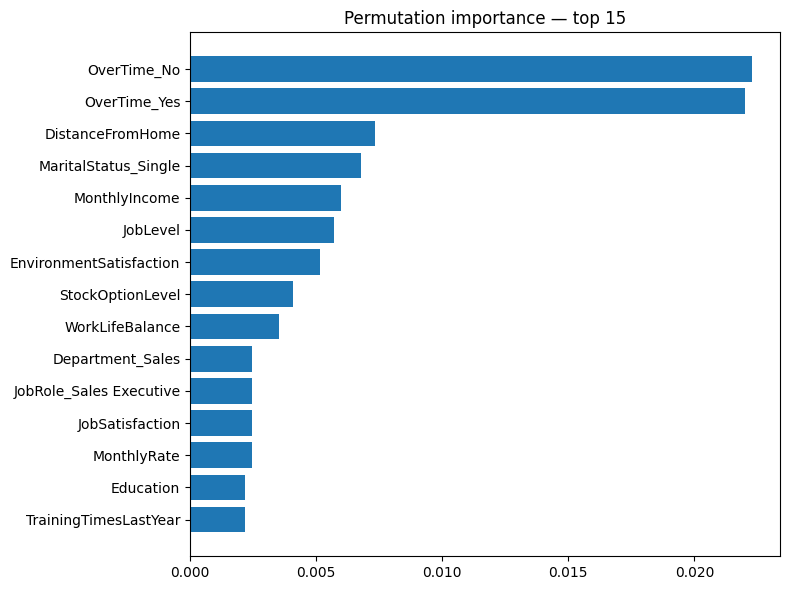

In [49]:
# === Cell 13 e`.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# CHOOSE your fitted pipeline here:
# model_pipe = best        # tuned Decision Tree from GridSearchCV
model_pipe = rf_pipe       # Random Forest pipeline you fitted in Cell 11c
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# 1) Transform holdout using the SAME preprocessor that was fit inside the pipe
prep = model_pipe.named_steps["prep"]
X_te_enc = prep.transform(X_te)

# 2) Grab the classifier
clf = model_pipe.named_steps["clf"]

# 3) Build encoded feature names robustly
feat_names = []
# categorical names from OneHotEncoder
if "onehot" in prep.named_transformers_:
    ohe = prep.named_transformers_["onehot"]

    cat_spec = prep.transformers_[0][2]  # ("onehot", OneHotEncoder, cat_cols)
    # If cat_spec is a list of names:
    if isinstance(cat_spec, (list, tuple)):
        cat_input_names = list(cat_spec)
    else:
        # in edge cases, ColumnTransformer may store indices; fallback to the training X columns
        cat_input_names = [c for c in X.columns if X[c].dtype == "object"]
    oh_names = list(ohe.get_feature_names_out(cat_input_names))
    feat_names.extend(oh_names)

# numeric names
if "scale" in prep.named_transformers_:
    # numeric spec is the third element of the second transformer tuple
    num_spec = prep.transformers_[1][2]
    if isinstance(num_spec, (list, tuple)):
        num_input_names = list(num_spec)
    else:
        num_input_names = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
    feat_names.extend(num_input_names)

# 4) Permutation importance
perm = permutation_importance(
    clf, X_te_enc, y_te,
    n_repeats=10, random_state=42, n_jobs=-1
)

imp = (
    pd.DataFrame({"feature": feat_names, "importance": perm.importances_mean})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

display(imp.head(20))

plt.figure(figsize=(8,6))
top = imp.head(15).iloc[::-1]
plt.barh(top["feature"], top["importance"])
plt.title("Permutation importance — top 15")
plt.tight_layout(); plt.show()


In [50]:
#cell 14
conn = sqlite3.connect(":memory:")
df.to_sql("employees", conn, index=False, if_exists="replace")

q1 = """
SELECT JobRole, Attrition, AVG(DistanceFromHome) AS avg_distance, COUNT(*) AS n
FROM employees
GROUP BY JobRole, Attrition
ORDER BY JobRole, Attrition;
"""
sql_q1 = pd.read_sql(q1, conn)
display(sql_q1.head(10))

q2 = """
SELECT Education, Attrition, AVG(MonthlyIncome) AS avg_income, COUNT(*) AS n
FROM employees
GROUP BY Education, Attrition
ORDER BY Education, Attrition;
"""
sql_q2 = pd.read_sql(q2, conn)
display(sql_q2)

conn.close()


,JobRole,Attrition,avg_distance,n
0,Healthcare Representative,No,9.204918,122
1,Healthcare Representative,Yes,17.666667,9
2,Human Resources,No,6.600000,40
3,Human Resources,Yes,13.416667,12
4,Laboratory Technician,No,9.329949,197
5,Laboratory Technician,Yes,9.661290,62
6,Manager,No,7.927835,97
7,Manager,Yes,10.000000,5
8,Manufacturing Director,No,9.533333,135
9,Manufacturing Director,Yes,8.800000,10


,Education,Attrition,avg_income,n
0,1,No,5926.129496,139
1,1,Yes,4360.161290,31
2,2,No,6586.058824,238
3,2,Yes,4282.545455,44
4,3,No,6882.919662,473
5,3,Yes,4770.242424,99
6,4,No,7087.814706,340
7,4,Yes,5335.155172,58
8,5,No,8559.906977,43
9,5,Yes,5850.200000,5


In [53]:
# === Cell 15 — Extra business sanity checks (fixed JSON-safe) ===
insights = {}

# 1) Overtime vs attrition
insights["OverTime"] = (
    df.groupby("OverTime")["Attrition"]
      .apply(lambda s: (s == "Yes").mean())
      .rename("attrition_rate")
      .reset_index()
      .to_dict("records")
)

# 2) Distance buckets vs attrition
bins = pd.cut(df["DistanceFromHome"], [0, 5, 10, 20, 100], include_lowest=True)
dist_df = (
    df.groupby(bins)["Attrition"]
      .apply(lambda s: (s == "Yes").mean())
      .rename("attrition_rate")
      .reset_index()
)

# convert Interval objects → string labels for JSON
dist_df["DistanceFromHome"] = dist_df["DistanceFromHome"].astype(str)
insights["DistanceFromHome_bins"] = dist_df.to_dict("records")

# 3) JobLevel vs attrition
insights["JobLevel"] = (
    df.groupby("JobLevel")["Attrition"]
      .apply(lambda s: (s == "Yes").mean())
      .rename("attrition_rate")
      .reset_index()
      .to_dict("records")
)

import json as _json
print(_json.dumps(insights, indent=2))


{
  "OverTime": [
    {
      "OverTime": "No",
      "attrition_rate": 0.10436432637571158
    },
    {
      "OverTime": "Yes",
      "attrition_rate": 0.30528846153846156
    }
  ],
  "DistanceFromHome_bins": [
    {
      "DistanceFromHome": "(-0.001, 5.0]",
      "attrition_rate": 0.13765822784810128
    },
    {
      "DistanceFromHome": "(5.0, 10.0]",
      "attrition_rate": 0.1446700507614213
    },
    {
      "DistanceFromHome": "(10.0, 20.0]",
      "attrition_rate": 0.2
    },
    {
      "DistanceFromHome": "(20.0, 100.0]",
      "attrition_rate": 0.22058823529411764
    }
  ],
  "JobLevel": [
    {
      "JobLevel": 1,
      "attrition_rate": 0.26335174953959484
    },
    {
      "JobLevel": 2,
      "attrition_rate": 0.09737827715355805
    },
    {
      "JobLevel": 3,
      "attrition_rate": 0.14678899082568808
    },
    {
      "JobLevel": 4,
      "attrition_rate": 0.04716981132075472
    },
    {
      "JobLevel": 5,
      "attrition_rate": 0.07246376811594203
   

In [58]:
# === Cell 16: Top drivers for Logistic (coef-based) ===
# Uses the already-fit `prep2` (ColumnTransformer on X_tr2) and `logit` (trained on SMOTE-balanced encoded X_tr2)
import numpy as np, pandas as pd

# Build feature names in the exact training order
ohe = prep2.named_transformers_["onehot"]
cat_spec = prep2.transformers_[0][2]  # cat columns used
if isinstance(cat_spec, (list, tuple)):
    cat_input_names = list(cat_spec)
else:
    # fallback: infer from dtypes
    cat_input_names = X_tr2.select_dtypes(include=["object"]).columns.tolist()

onehot_names = list(ohe.get_feature_names_out(cat_input_names))
num_spec = prep2.transformers_[1][2]
num_input_names = list(num_spec) if isinstance(num_spec, (list, tuple)) else \
                  X_tr2.select_dtypes(include=[np.number]).columns.tolist()
feature_names = onehot_names + num_input_names

# Logistic coef_ shape: (1, n_features)
coefs = logit.coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

top5 = coef_df.sort_values("abs_coef", ascending=False).head(5)
display(top5)

print("\nTop 5 drivers (direction):")
for _, r in top5.iterrows():
    direction = "↑ risk" if r["coef"] > 0 else "↓ risk"
    print(f"- {r['feature']}: {direction} (coef={r['coef']:.4f})")


,feature,coef,abs_coef
19,JobRole_Research Director,-1.876933,1.876933
22,JobRole_Sales Representative,1.403974,1.403974
16,JobRole_Laboratory Technician,1.212136,1.212136
0,BusinessTravel_Non-Travel,-1.041792,1.041792
27,OverTime_Yes,0.997357,0.997357



Top 5 drivers (direction):
- JobRole_Research Director: ↓ risk (coef=-1.8769)
- JobRole_Sales Representative: ↑ risk (coef=1.4040)
- JobRole_Laboratory Technician: ↑ risk (coef=1.2121)
- BusinessTravel_Non-Travel: ↓ risk (coef=-1.0418)
- OverTime_Yes: ↑ risk (coef=0.9974)


In [59]:
# === Cell 17: Export Excel + predictions CSV ===
import json
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve

# Metrics for each model (holdout)
def pr_auc(y_true, proba):
    return average_precision_score(y_true, proba)

# Logistic tuned threshold from your earlier sweep (recompute to be safe)
import numpy as np
ts = np.linspace(0.05, 0.9, 86)
f1s = [f1_score(y_te2, (proba_log >= t).astype(int)) for t in ts]
t_logit = ts[int(np.argmax(f1s))]
pred_logit = (proba_log >= t_logit).astype(int)

# If you ran RF/XGB sections:
rf_present = "proba_rf" in globals()
xgb_present = "proba_xgb" in globals()

# Tables
metrics = {
    "Logistic": {
        "ROC_AUC": float(roc_auc_score(y_te2, proba_log)),
        "PR_AUC": float(pr_auc(y_te2, proba_log)),
        "Best_threshold": float(t_logit),
        "F1_at_best_t": float(f1_score(y_te2, pred_logit)),
        "Recall_at_best_t": float((pred_logit & (y_te2==1)).sum() / (y_te2==1).sum())
    }
}
if rf_present:
    ts_rf = np.linspace(0.05, 0.9, 86)
    f1s_rf = [f1_score(y_te, (proba_rf >= t).astype(int)) for t in ts_rf]
    t_rf = ts_rf[int(np.argmax(f1s_rf))]
    pred_rf = (proba_rf >= t_rf).astype(int)
    metrics["RandomForest"] = {
        "ROC_AUC": float(roc_auc_score(y_te, proba_rf)),
        "PR_AUC": float(pr_auc(y_te, proba_rf)),
        "Best_threshold": float(t_rf),
        "F1_at_best_t": float(f1_score(y_te, pred_rf)),
        "Recall_at_best_t": float((pred_rf & (y_te==1)).sum() / (y_te==1).sum())
    }
if xgb_present:
    ts_x = np.linspace(0.05, 0.9, 86)
    f1s_x = [f1_score(y_te, (proba_xgb >= t).astype(int)) for t in ts_x]
    t_xgb = ts_x[int(np.argmax(f1s_x))]
    pred_xgb = (proba_xgb >= t_xgb).astype(int)
    metrics["XGBoost"] = {
        "ROC_AUC": float(roc_auc_score(y_te, proba_xgb)),
        "PR_AUC": float(pr_auc(y_te, proba_xgb)),
        "Best_threshold": float(t_xgb),
        "F1_at_best_t": float(f1_score(y_te, pred_xgb)),
        "Recall_at_best_t": float((pred_xgb & (y_te==1)).sum() / (y_te==1).sum())
    }

metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={"index":"model"})
display(metrics_df)

# Confusion matrices at tuned thresholds
cm_log = pd.DataFrame(confusion_matrix(y_te2, pred_logit),
                      index=["Actual_0","Actual_1"], columns=["Pred_0","Pred_1"])

# Save permutation importance if you computed (imp from RF or DT); if absent, use logistic top5
drivers_df = top5.copy() if "top5" in globals() else coef_df.sort_values("abs_coef", ascending=False).head(10)

# Write Excel
with pd.ExcelWriter("attrition_outputs.xlsx", engine="openpyxl") as xw:
    attrition_share.to_frame().to_excel(xw, sheet_name="attrition_share")
    pivot_dist.to_excel(xw, sheet_name="dist_by_role_attrition")
    pivot_income.to_excel(xw, sheet_name="income_by_edu_attrition")
    metrics_df.to_excel(xw, sheet_name="model_metrics", index=False)
    cm_log.to_excel(xw, sheet_name="cm_logistic")
    drivers_df.to_excel(xw, sheet_name="top_drivers", index=False)

# Predictions CSV for the holdout (logistic)
pred_out = X_te2.copy()
pred_out["y_true"] = y_te2.values
pred_out["proba_logit"] = proba_log
pred_out["pred_logit@t*"] = pred_logit
if rf_present:
    pred_out["proba_rf"] = proba_rf[:len(pred_out)]
    pred_out["pred_rf@t*"] = pred_rf[:len(pred_out)]
if xgb_present:
    pred_out["proba_xgb"] = proba_xgb[:len(pred_out)]
    pred_out["pred_xgb@t*"] = pred_xgb[:len(pred_out)]

pred_out.to_csv("holdout_predictions.csv", index=False)
print("Wrote attrition_outputs.xlsx and holdout_predictions.csv")


,model,ROC_AUC,PR_AUC,Best_threshold,F1_at_best_t,Recall_at_best_t
0,Logistic,0.811146,0.555247,0.61,0.539683,0.576271
1,RandomForest,0.769678,0.438289,0.37,0.533333,0.610169
2,XGBoost,0.778345,0.515748,0.33,0.507463,0.576271


Wrote attrition_outputs.xlsx and holdout_predictions.csv


In [60]:
# === Cell 18: Save deployable bundle (preprocess + logistic + threshold) ===
import pickle, json

bundle = {
    "preprocess": prep2,       # ColumnTransformer fitted on training data
    "model": logit,            # LogisticRegression fitted on SMOTE-balanced encoded data
    "threshold": float(t_logit)
}
with open("final_model_bundle.pkl", "wb") as f:
    pickle.dump(bundle, f)

with open("final_threshold.json", "w") as f:
    json.dump({"threshold": float(t_logit)}, f)

print("Saved final_model_bundle.pkl and final_threshold.json")


Saved final_model_bundle.pkl and final_threshold.json
